In [ ]:
!unzip -j "/content/drive/MyDrive/songs.zip" "songs/*" -d "/content/songs/"

In [ ]:
!pip install torch torchaudio librosa transformers torch-audiomentations

In [ ]:
!pip install --upgrade numba

Checking cache at cache...
Total cached files: 327
Using PyTorch Transformer backend with 4 layers, 8 heads.
[Epoch 1] loss=51.1303
[Epoch 2] loss=36.3485
[Epoch 3] loss=30.0580
[Epoch 4] loss=26.7136
[Epoch 5] loss=25.1210
[Epoch 6] loss=23.2972
[Epoch 7] loss=22.9765
[Epoch 8] loss=22.0190
[Epoch 9] loss=21.6524
[Epoch 10] loss=21.2875
[Epoch 11] loss=21.0871
[Epoch 12] loss=21.3692
[Epoch 13] loss=20.4946
[Epoch 14] loss=21.3765
[Epoch 15] loss=20.5771
Model saved as bt_audio_model.pt
Checking cache at cache...
Total cached files: 327
Using PyTorch Transformer backend with 4 layers, 8 heads.
Saved 327 embeddings to embedding_output/
t-SNE plot saved to tsne_song_level_embeddings.png


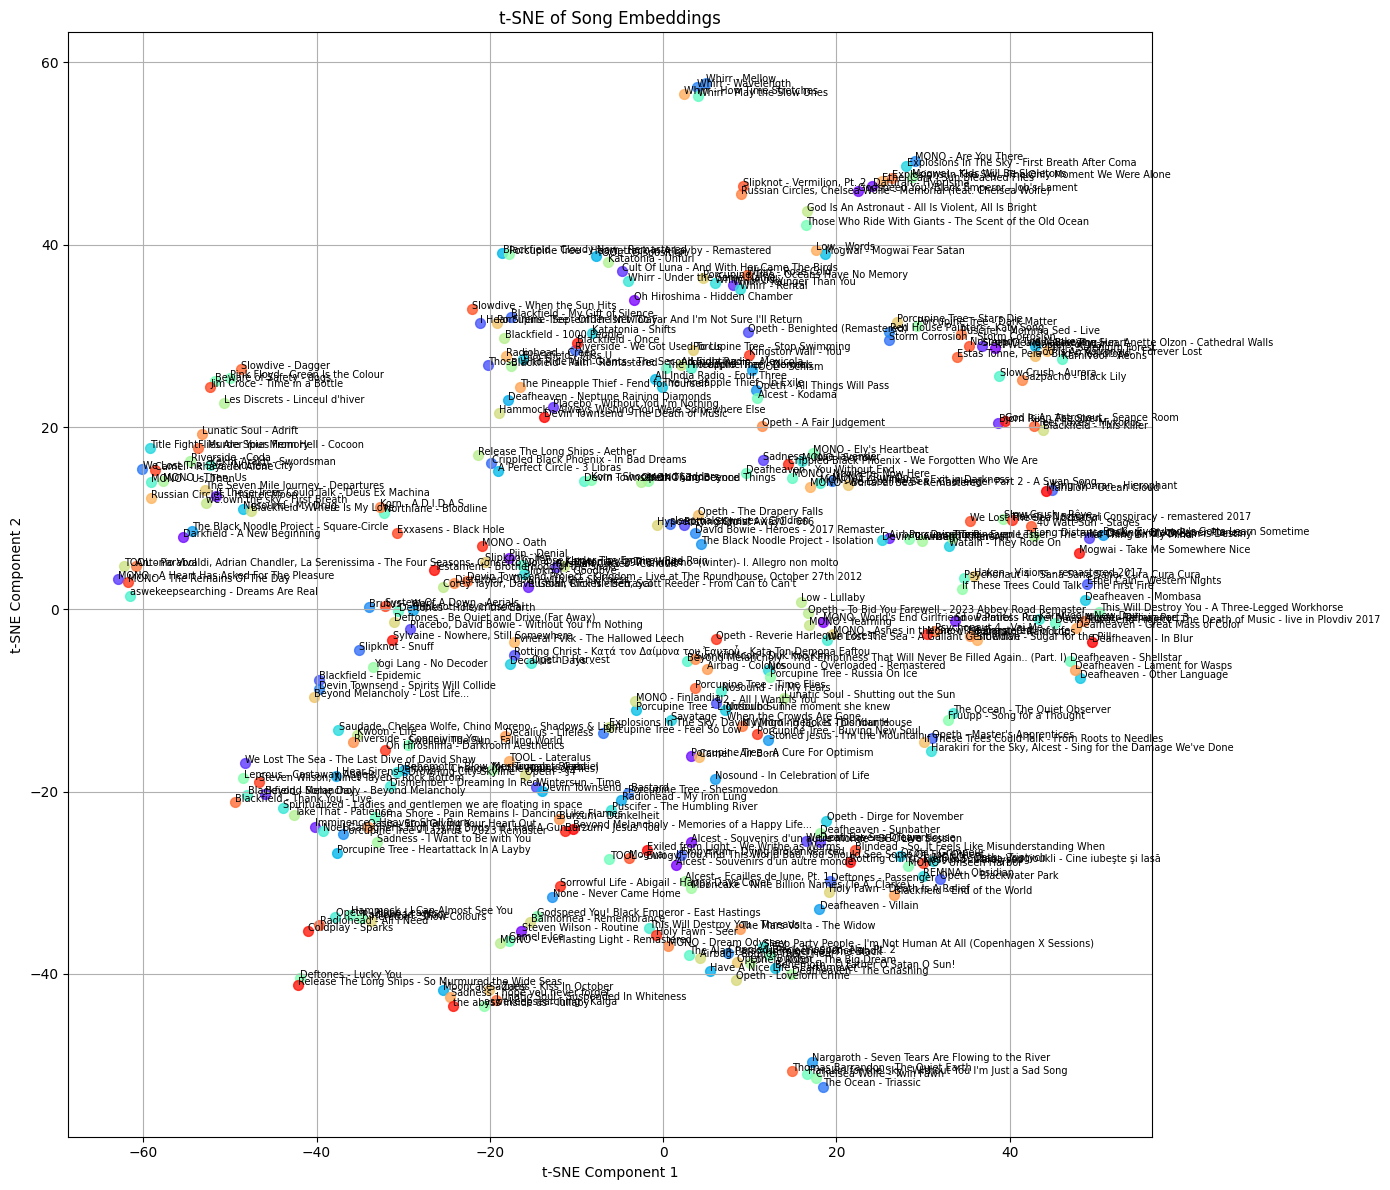

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch_audiomentations import Compose, Gain
from transformers import BertModel, BertConfig
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Constants ---
TARGET_SR = 8000
CLIP_DURATION_S = 30
CLIP_SAMPLES = int(CLIP_DURATION_S * TARGET_SR)
N_SEGMENTS = 100  # Fixed number of segments per sample


# --- Data Loading and Preprocessing ---
class AudioClipDataset(Dataset):
    def __init__(self, data_folder, target_sr=TARGET_SR, clip_duration_s=CLIP_DURATION_S,
                         segment_samples=30000, n_segments=N_SEGMENTS, device="cuda",
                         cache_dir="cache", overwrite_cache=False, mode="contrastive"):
        self.data_folder = data_folder
        self.target_sr = target_sr
        self.clip_samples = int(clip_duration_s * target_sr)
        self.segment_samples = segment_samples
        self.n_segments = n_segments
        self.device = device
        self.mode = mode
        self.cache_dir = Path(cache_dir)
        self.overwrite_cache = overwrite_cache
        self.cache_dir.mkdir(exist_ok=True)

        # --- Augmentation pipeline (torch-audiomentations) ---
        self.augment = Compose(
            transforms=[
                Gain(min_gain_in_db=-6.0, max_gain_in_db=6.0, p=0.5)],
                p=1.0, output_type="tensor"
        )
        # move to GPU if tensors are on GPU
        if device == "cuda":
            self.augment.to("cuda")

        self.file_paths = []
        for root, _, files in os.walk(data_folder):
            for file in files:
                if file.endswith(".mp3"):
                    self.file_paths.append(os.path.join(root, file))

        self.cached_paths = self._prepare_cached_segments()

    def _prepare_cached_segments(self):
        cached = []
        print(f"Checking cache at {self.cache_dir}...")
        for f_path in self.file_paths:
            basename = Path(f_path).stem
            cache_file = self.cache_dir / f"{basename}.pt"

            if not cache_file.exists() or self.overwrite_cache:
                try:
                    y, sr = librosa.load(f_path, sr=None, mono=True)
                    if sr != self.target_sr:
                        y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

                    num_clips = len(y) // self.clip_samples
                    all_segments = []

                    for i in range(num_clips):
                        clip = y[i * self.clip_samples : (i + 1) * self.clip_samples]
                        clip_tensor = torch.tensor(clip, dtype=torch.float32)
                        segments = self.segment_audio(clip_tensor)
                        if segments:
                            all_segments.append(torch.stack(segments))

                    if all_segments:
                        all_segments_tensor = torch.cat(all_segments, dim=0)  # shape: (num_total_segments, 1, segment_samples)
                        torch.save(all_segments_tensor, cache_file)
                        print(f"Cached: {cache_file}")
                    else:
                        print(f"No valid segments for: {f_path}")

                except Exception as e:
                    print(f"Failed to process {f_path}: {e}")

            if cache_file.exists():
                cached.append(str(cache_file))
        print(f"Total cached files: {len(cached)}")
        return cached

    def segment_audio(self, audio_tensor, hop_samples=None):
        if hop_samples is None:
            hop_samples = self.segment_samples

        segments = []
        for start in range(0, len(audio_tensor), hop_samples):
            chunk = audio_tensor[start : start + self.segment_samples]

            if len(chunk) < self.segment_samples:
                padding = self.segment_samples - len(chunk)
                chunk = torch.nn.functional.pad(chunk, (0, padding))

            # Final shape: (1, 30000)
            chunk = chunk.unsqueeze(0)
            segments.append(chunk)
        return segments

    def __len__(self):
        return len(self.cached_paths)

    def __getitem__(self, idx):
        tensors = torch.load(self.cached_paths[idx], map_location=self.device)
        tensor = tensors  # shape: (total_segments, 1, segment_samples)

        # Pad or truncate to fixed number of segments
        n = tensor.shape[0]
        if n > self.n_segments:
            tensor = tensor[:self.n_segments]
        elif n < self.n_segments:
            pad = torch.zeros(self.n_segments - n, 1, self.segment_samples, device=tensor.device)
            tensor = torch.cat([tensor, pad], dim=0)

        song_name = os.path.basename(self.cached_paths[idx]).replace(".pt", "")

        if self.mode == "contrastive":
            # Ensure independent augmentations
            aug1 = self.augment(tensor.clone(), sample_rate=self.target_sr)
            aug2 = self.augment(tensor.clone(), sample_rate=self.target_sr)
            return aug1.to(self.device), aug2.to(self.device), song_name

        elif self.mode == "inference":
            return tensor.to(self.device), song_name

        else:
            raise ValueError(f"Invalid mode: {self.mode}. Use 'contrastive' or 'inference'.")

# --- Augmentation function (currently unused, but kept for context) ---
def augment_tensor_audio(tensor, sr=8000):
    tensor = tensor.clone()

    for i in range(tensor.shape[0]):
        x = tensor[i, 0]  # shape: (30000,)

        # --- Add noise ---
        if torch.rand(1).item() < 0.3:
            x = x + 0.01 * torch.randn_like(x)
            x = torch.clamp(x, -1.0, 1.0)

        # --- Time stretch (linear interpolation) ---
        if torch.rand(1).item() < 0.3:
            factor = torch.empty(1).uniform_(0.8, 1.2).item()
            new_len = int(x.shape[-1] * factor)
            x = F.interpolate(x[None, None, :], size=new_len, mode="linear", align_corners=False).squeeze()

        # --- Pitch shift (resampling approximation) ---
        if torch.rand(1).item() < 0.3:
            shift = torch.randint(-2, 3, (1,)).item()
            pitch_factor = 2 ** (shift / 12.0)
            new_len = int(x.shape[-1] / pitch_factor)
            x = F.interpolate(x[None, None, :], size=new_len, mode="linear", align_corners=False).squeeze()

        # --- Pad or truncate to target length ---
        if x.shape[0] < 30000:
            x = torch.cat([x, torch.zeros(30000 - x.shape[0], device=x.device)])
        else:
            x = x[:30000]

        tensor[i, 0] = x

    return tensor


# --- CORRECTED: Residual Block Definition ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, pool_kernel_size=None, pool_stride=None, pool_padding=None):
        super(ResidualBlock, self).__init__()
        # First convolution: potentially downsamples
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)


        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            # The 1x1 conv in the shortcut path should apply the same stride
            # as the first conv in the main path to match spatial dimensions.
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        self.pool = None
        if pool_kernel_size is not None:
            self.pool = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

    def forward(self, x):

        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)


        if out.shape[2] != identity.shape[2]:

            identity = identity[..., :out.shape[2]] # Crop identity to match 'out' length


        out += identity
        out = self.relu(out)

        if self.pool is not None:
            out = self.pool(out)
        return out


# --- 3. SoundNet-style CNN Frontend ---
class SoundNetCNN(nn.Module):
    def __init__(self):
        super(SoundNetCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv1d(1, 32, kernel_size=64, stride=8, padding=28, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool1d(kernel_size=8, stride=2, padding=3)

        # Block 2
        self.conv2 = nn.Conv1d(32, 64, kernel_size=32, stride=4, padding=14, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool1d(kernel_size=8, stride=2, padding=3)

        # Block 3
        # Stride here means downsampling will be handled by conv1 of the ResidualBlock.
        self.res_block3 = ResidualBlock(
            in_channels=64,
            out_channels=128,
            kernel_size=16, # kernel for the first conv of residual block
            stride=2,       # stride for the first conv of residual block (downsampling)
            padding=7,      # padding for both convs inside the residual block
        )

        # Block 4
        self.res_block4 = ResidualBlock(
            in_channels=128,
            out_channels=256,
            kernel_size=8,
            stride=2,
            padding=3,
        )

        # Block 5
        self.res_block5 = ResidualBlock(
            in_channels=256,
            out_channels=512,
            kernel_size=4,
            stride=2,
            padding=1,
            pool_kernel_size=4, # This pooling follows the convs within the block
            pool_stride=2,
            pool_padding=1
        )

        # Block 6
        self.conv6 = nn.Conv1d(512, 1024, kernel_size=4, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.relu6(self.bn6(self.conv6(x)))
        x = x.permute(0, 2, 1) # (B*N, T, D) for Transformer
        return x


# Final output sequence length (T) before permute will be 13.
# Final output feature dimension (D) will be 1024 (output channels of conv6).

# --- AttentionPooling  ---
class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, 1)

    def forward(self, x):  # x: (B, T, D)
        attn_weights = torch.softmax(self.query(x), dim=1)  # (B, T, 1)
        pooled = (x * attn_weights).sum(dim=1)              # (B, D)
        return pooled

# --- PositionalEncoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- LearnablePositionalEncoding ---
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int, dropout: float = 0.1):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)  # shape: (1, seq_len)
        pos_embed = self.pos_embedding(positions)  # shape: (1, seq_len, d_model)
        x = x + pos_embed
        return self.dropout(x)

# --- AudioTransformerEncoder ---
class AudioTransformerEncoder(nn.Module):
    def __init__(self, input_dim=512, num_heads=8, num_layers=6, use_attention_pooling=False,
                 hidden_dim_multiplier=4, dropout=0.1, output_embedding_dim=256,
                 use_learnable_positional=False, max_len=20):
        super(AudioTransformerEncoder, self).__init__()

        self.use_attention_pooling = use_attention_pooling
        if use_attention_pooling:
            self.attn_pool = AttentionPooling(input_dim)

        # Positional Encoding
        if use_learnable_positional:
            self.pos_encoder = LearnablePositionalEncoding(max_len=max_len, d_model=input_dim, dropout=dropout)
        else:
            self.pos_encoder = PositionalEncoding(d_model=input_dim, dropout=dropout, max_len=max_len)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=num_heads,
            dim_feedforward=input_dim * hidden_dim_multiplier,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Projection head to final embedding dim
        self.projection_head = nn.Linear(input_dim, output_embedding_dim)

    def forward(self, x_seq):  # x_seq: (B, T, D)
        x_seq = self.pos_encoder(x_seq)
        transformer_output = self.transformer_encoder(x_seq)
        if self.use_attention_pooling:
            pooled_output = self.attn_pool(transformer_output)
        else:
            pooled_output = transformer_output.mean(dim=1)
        embedding = self.projection_head(pooled_output)
        return embedding

# --- BERTAudioEncoder ---
class BERTAudioEncoder(nn.Module):
    def __init__(self, input_dim=512, num_heads=8, num_layers=6, dropout=0.1,
                 output_embedding_dim=256, max_seq_len=20):
        super(BERTAudioEncoder, self).__init__()

        self.bert_config = BertConfig(
            hidden_size=input_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=input_dim * 4,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
            max_position_embeddings=max_seq_len,
            initializer_range=0.02
        )

        self.bert_model = BertModel(self.bert_config)
        self.attn_pool = AttentionPooling(input_dim)
        self.projection_head = nn.Linear(input_dim, output_embedding_dim)

    def forward(self, x_seq):  # x_seq: (B, T, D)
        attention_mask = torch.ones(x_seq.shape[0], x_seq.shape[1], device=x_seq.device)
        bert_outputs = self.bert_model(inputs_embeds=x_seq, attention_mask=attention_mask)
        last_hidden_state = bert_outputs.last_hidden_state  # (B, T, D)

        pooled_output = self.attn_pool(last_hidden_state)  # (B, D)
        embedding = self.projection_head(pooled_output)    # (B, output_dim)
        return embedding

# --- AudioEmbedder ---
class AudioEmbedder(nn.Module):
    def __init__(self, config: dict):
        super(AudioEmbedder, self).__init__()
        self.config = config
        self.cnn_frontend = SoundNetCNN()
        self.transformer_type = config["transformer_type"]

        if self.transformer_type == 'bert':
            print(f"Using BERT backend with {config['transformer_layers']} layers, {config['transformer_heads']} heads.")
            self.transformer_backend = BERTAudioEncoder(
                input_dim=config["cnn_output_dim"],
                num_heads=config["transformer_heads"],
                num_layers=config["transformer_layers"],
                dropout=0.1,
                output_embedding_dim=config["final_embedding_dim"],
                max_seq_len=config["bert_max_seq_len"]
            )

        elif self.transformer_type == 'pytorch':
            print(f"Using PyTorch Transformer backend with {config['transformer_layers']} layers, {config['transformer_heads']} heads.")
            self.transformer_backend = AudioTransformerEncoder(
                input_dim=config["cnn_output_dim"],
                num_heads=config["transformer_heads"],
                num_layers=config["transformer_layers"],
                dropout=0.1,
                output_embedding_dim=config["final_embedding_dim"],
                use_learnable_positional=config.get("use_learnable_positional", False),
                max_len=config.get("bert_max_seq_len", 20), # max_len in AudioTransformerEncoder is bert_max_seq_len
                use_attention_pooling=config.get("use_attention_pooling", False)
            )
        else:
            raise ValueError(f"Unsupported transformer_type: {self.transformer_type}")

    def forward(self, x):  # x: (B, N, 1, 30000)
        B, N, C, L = x.shape
        x = x.view(B * N, C, L)

        cnn_features = self.cnn_frontend(x)  # (B*N, T, D)
        embedding = self.transformer_backend(cnn_features)  # (B*N, output_dim)
        embedding = embedding.view(B, N, -1)  # (B, N, output_dim)
        return embedding


# --- Barlow Twins Wrapper + Loss ---
class AudioBarlowTwinsWrapper(nn.Module):
    def __init__(self, encoder: nn.Module, proj_dim: int = 128, lambd: float = 5e-3):
        super().__init__()
        self.encoder = encoder
        self.lambd = lambd

        # The input to the projector is encoder.config["final_embedding_dim"]
        self.projector = nn.Sequential(
            nn.Linear(encoder.config["final_embedding_dim"], proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, x):  # x: (B, N, 1, 30000)
        emb = self.encoder(x)  # (B, N, D)
        emb = emb.mean(dim=1)  # (B, D)
        z = self.projector(emb)  # (B, proj_dim)
        return z

    @staticmethod
    def _off_diagonal(mat: torch.Tensor) -> torch.Tensor:
        n, _ = mat.shape
        return mat.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def loss(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        N, D = z1.shape

        z1 = (z1 - z1.mean(0)) / z1.std(0)
        z2 = (z2 - z2.mean(0)) / z2.std(0)

        c = (z1.T @ z2) / N

        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = self._off_diagonal(c).pow_(2).sum()

        return on_diag + self.lambd * off_diag

# --- Barlow Twins Training Loop ---
def train_barlow_twins(batch_size=32,
                       accum_steps=1,
                       proj_dim=256,
                       use_amp=True,
                       audio_embedder_config=None): # Added config parameter
    if audio_embedder_config is None:
        raise ValueError("audio_embedder_config must be provided to train_barlow_twins.")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    scaler = GradScaler(enabled=use_amp)

    dataset = AudioClipDataset(
        #data_folder="/content/drive/MyDrive/spotify_data",
        data_folder="/content/songs/songs",
        device=device,
        mode="contrastive",
    )
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0) # num_workers can be increased

    # Backbone encoder
    encoder = AudioEmbedder(audio_embedder_config).to(device)

    # Wrap with Barlow Twins head
    model = AudioBarlowTwinsWrapper(encoder, proj_dim=proj_dim).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    epochs = 15

    for epoch in range(epochs):
        model.train()
        running = 0.0
        opt.zero_grad(set_to_none=True)

        for step, (aug1, aug2, _) in enumerate(loader):
            aug1, aug2 = aug1.to(device), aug2.to(device)

            with autocast(device_type='cuda', enabled=use_amp):
                z1 = model(aug1)
                z2 = model(aug2)
                loss = model.loss(z1, z2) / accum_steps

            scaler.scale(loss).backward()

            if (step + 1) % accum_steps == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)

            running += loss.item() * accum_steps

        print(f"[Epoch {epoch+1}] loss={running/len(loader):.4f}")

    torch.save(model.state_dict(), "bt_audio_model.pt")
    print("Model saved as bt_audio_model.pt")

# --- Inference / Embedding Extraction ---
def extract_and_save_embeddings(audio_embedder_config, proj_dim=256, output_dir="embedding_output", batch_size=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    dataset = AudioClipDataset(
        #data_folder="/content/drive/MyDrive/spotify_data",
        data_folder="/content/songs/songs",
        device=device,
        mode="inference",
    )

    # Load the trained Barlow Twins model
    model = AudioBarlowTwinsWrapper(AudioEmbedder(audio_embedder_config), proj_dim=proj_dim).to(device)
    model.load_state_dict(torch.load("bt_audio_model.pt", map_location=device))
    model.eval()

    os.makedirs(output_dir, exist_ok=True)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for x, name in loader:  # x: (B, N, 1, 30000)
            x = x.to(device)
            z = model(x)  # (B, proj_dim)
            z = F.normalize(z, dim=-1)  # good for FAISS / t-SNE
            all_embeddings.append(z.cpu())
            all_labels.extend(name)

    np.save(Path(output_dir) / "song_embeddings.npy",
             torch.cat(all_embeddings).numpy())

    (Path(output_dir) / "song_labels.txt").write_text("\n".join(all_labels))
    print(f"Saved {len(all_labels)} embeddings to {output_dir}/")

# --- Plotting Visualization (unchanged) ---
def plot_tsne_song_visualization(embeddings, song_filenames, title="t-SNE of Song Embeddings", n_components=2, perplexity=5.0, max_iter=1000):
    if embeddings.shape[0] <= 1:
        print("Not enough embeddings to plot t-SNE (need > 1).")
        return

    # Normalize for better clustering visualization
    embeddings = F.normalize(torch.tensor(embeddings), dim=1).cpu().numpy()

    actual_perplexity = min(perplexity, embeddings.shape[0] - 1.0)
    if actual_perplexity <= 0: actual_perplexity = 5.0

    #print(f"Performing t-SNE on {embeddings.shape[0]} song embeddings (perplexity={actual_perplexity})...")
    tsne = TSNE(n_components=n_components, random_state=42, perplexity=actual_perplexity, max_iter=max_iter, init='pca', learning_rate='auto')
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(14, 12))
    colors = cm.rainbow(np.linspace(0, 1, len(song_filenames)))

    for i in range(embeddings_2d.shape[0]):
        short_filename = song_filenames[i]
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[i % len(colors)], alpha=0.8, s=50)
        plt.text(embeddings_2d[i, 0]+0.02, embeddings_2d[i, 1]+0.02, short_filename, fontsize=7)

    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("tsne_song_level_embeddings.png")
    print("t-SNE plot saved to tsne_song_level_embeddings.png")
    plt.show()


# --- Main entry-point ---
if __name__ == "__main__":
    # Output of improved SoundNetCNN: (B*N, 13, 1024)
    # So, cnn_output_dim = 1024, bert_max_seq_len = 13
    audio_embedder_config = {
        "cnn_output_dim": 1024,
        "transformer_type": "pytorch",  # or "bert"
        "transformer_heads": 8,
        "transformer_layers": 4,
        "dropout": 0.1,
        "final_embedding_dim": 256,
        "bert_max_seq_len": 13,
        "use_learnable_positional": False,
        "use_attention_pooling": True
    }

    # 1) self-supervised training
    train_barlow_twins(audio_embedder_config=audio_embedder_config)


    # 2) extract embeddings and save them
    extract_and_save_embeddings(audio_embedder_config=audio_embedder_config,
        output_dir="embedding_output",
        batch_size=8,
        proj_dim=256
    )

    # 3) load embeddings + labels
    embeddings = np.load("embedding_output/song_embeddings.npy")
    with open("embedding_output/song_labels.txt") as f:
        song_filenames = [line.strip() for line in f]

    # 4) visualise
    plot_tsne_song_visualization(embeddings, song_filenames)



# Get songs by cosine dist.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest_neighbors(song_query, embeddings, song_names, top_k=5):
    """
    Given a song name, find the top_k most similar songs based on cosine similarity.
    Assumes embeddings are already normalized.
    """
    if song_query not in song_names:
        raise ValueError(f"'{song_query}' not found in song list.")

    idx = song_names.index(song_query)
    query_vec = embeddings[idx].reshape(1, -1)

    # Cosine similarity to all others
    similarities = cosine_similarity(query_vec, embeddings)[0]

    # Get top_k excluding self
    nearest_indices = np.argsort(similarities)[::-1]
    nearest_indices = [i for i in nearest_indices if i != idx][:top_k]

    results = [(song_names[i], similarities[i]) for i in nearest_indices]
    return results


In [ ]:
# Example usage:
query_song = "Whirr - Play the Slow Ones"
try:
    neighbors = find_nearest_neighbors(query_song, embeddings, song_names, top_k=5)
    print(f"\nTop 5 similar songs to '{query_song}':")
    for name, score in neighbors:
        print(f"{name} (score: {score:.4f})")
except ValueError as e:
    print(e)



Top 5 similar songs to 'Whirr - Play the Slow Ones':
Whirr - Wavelength (score: 0.9891)
Whirr - Rental (score: 0.9533)
Whirr - How Time Stretches (score: 0.9193)
Whirr - Mellow (score: 0.8647)
Slowdive - When the Sun Hits (score: 0.8468)


# Plot for High-res visualization (for poster)

In [ ]:
def plot_tsne_song_visualization(emb, filenames,
                                 title="t-SNE of Song Embeddings",
                                 n_components=2, perplexity=5.0,
                                 max_iter=1000, dpi=600, outfile="tsne_song_level_embeddings.png"):

    if emb.shape[0] <= 1:
        print("Need >1 embedding for t-SNE")
        return

    emb = F.normalize(torch.tensor(emb), dim=1).cpu().numpy()
    perplexity = min(perplexity, emb.shape[0] - 1) or 5.0

    tsne = TSNE(n_components=n_components, random_state=42,
                perplexity=perplexity, max_iter=max_iter,
                init='pca', learning_rate='auto')
    emb2d = tsne.fit_transform(emb)

    # Extract artist name from filename (before first dash)
    def extract_artist(name):
        return name.split(" - ")[0] if " - " in name else name

    artist_names = [extract_artist(f) for f in filenames]
    unique_artists = sorted(set(artist_names))
    palette = sns.color_palette("hls", len(unique_artists))
    artist_to_color = {artist: palette[i] for i, artist in enumerate(unique_artists)}

    # Plot
    plt.figure(figsize=(14, 12), dpi=dpi)

    for (x, y), artist, full_name in zip(emb2d, artist_names, filenames):
        color = artist_to_color[artist]
        plt.scatter(x, y, color=color, alpha=0.9, s=50, edgecolors='k', linewidths=0.3)
        plt.text(x + 0.02, y + 0.02, full_name, fontsize=8)  # full file name shown here

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE Component 1", fontsize=14)
    plt.ylabel("t-SNE Component 2", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(outfile, dpi=dpi, bbox_inches="tight")
    print(f"Saved high-res plot → {outfile}")
    plt.show()


In [ ]:
plot_tsne_song_visualization(embeddings, song_names)

Saved high-res plot → tsne_song_level_embeddings.png


# Compare VG-Gish clusters against the clusters generated by us. 

400 songs present in both sets


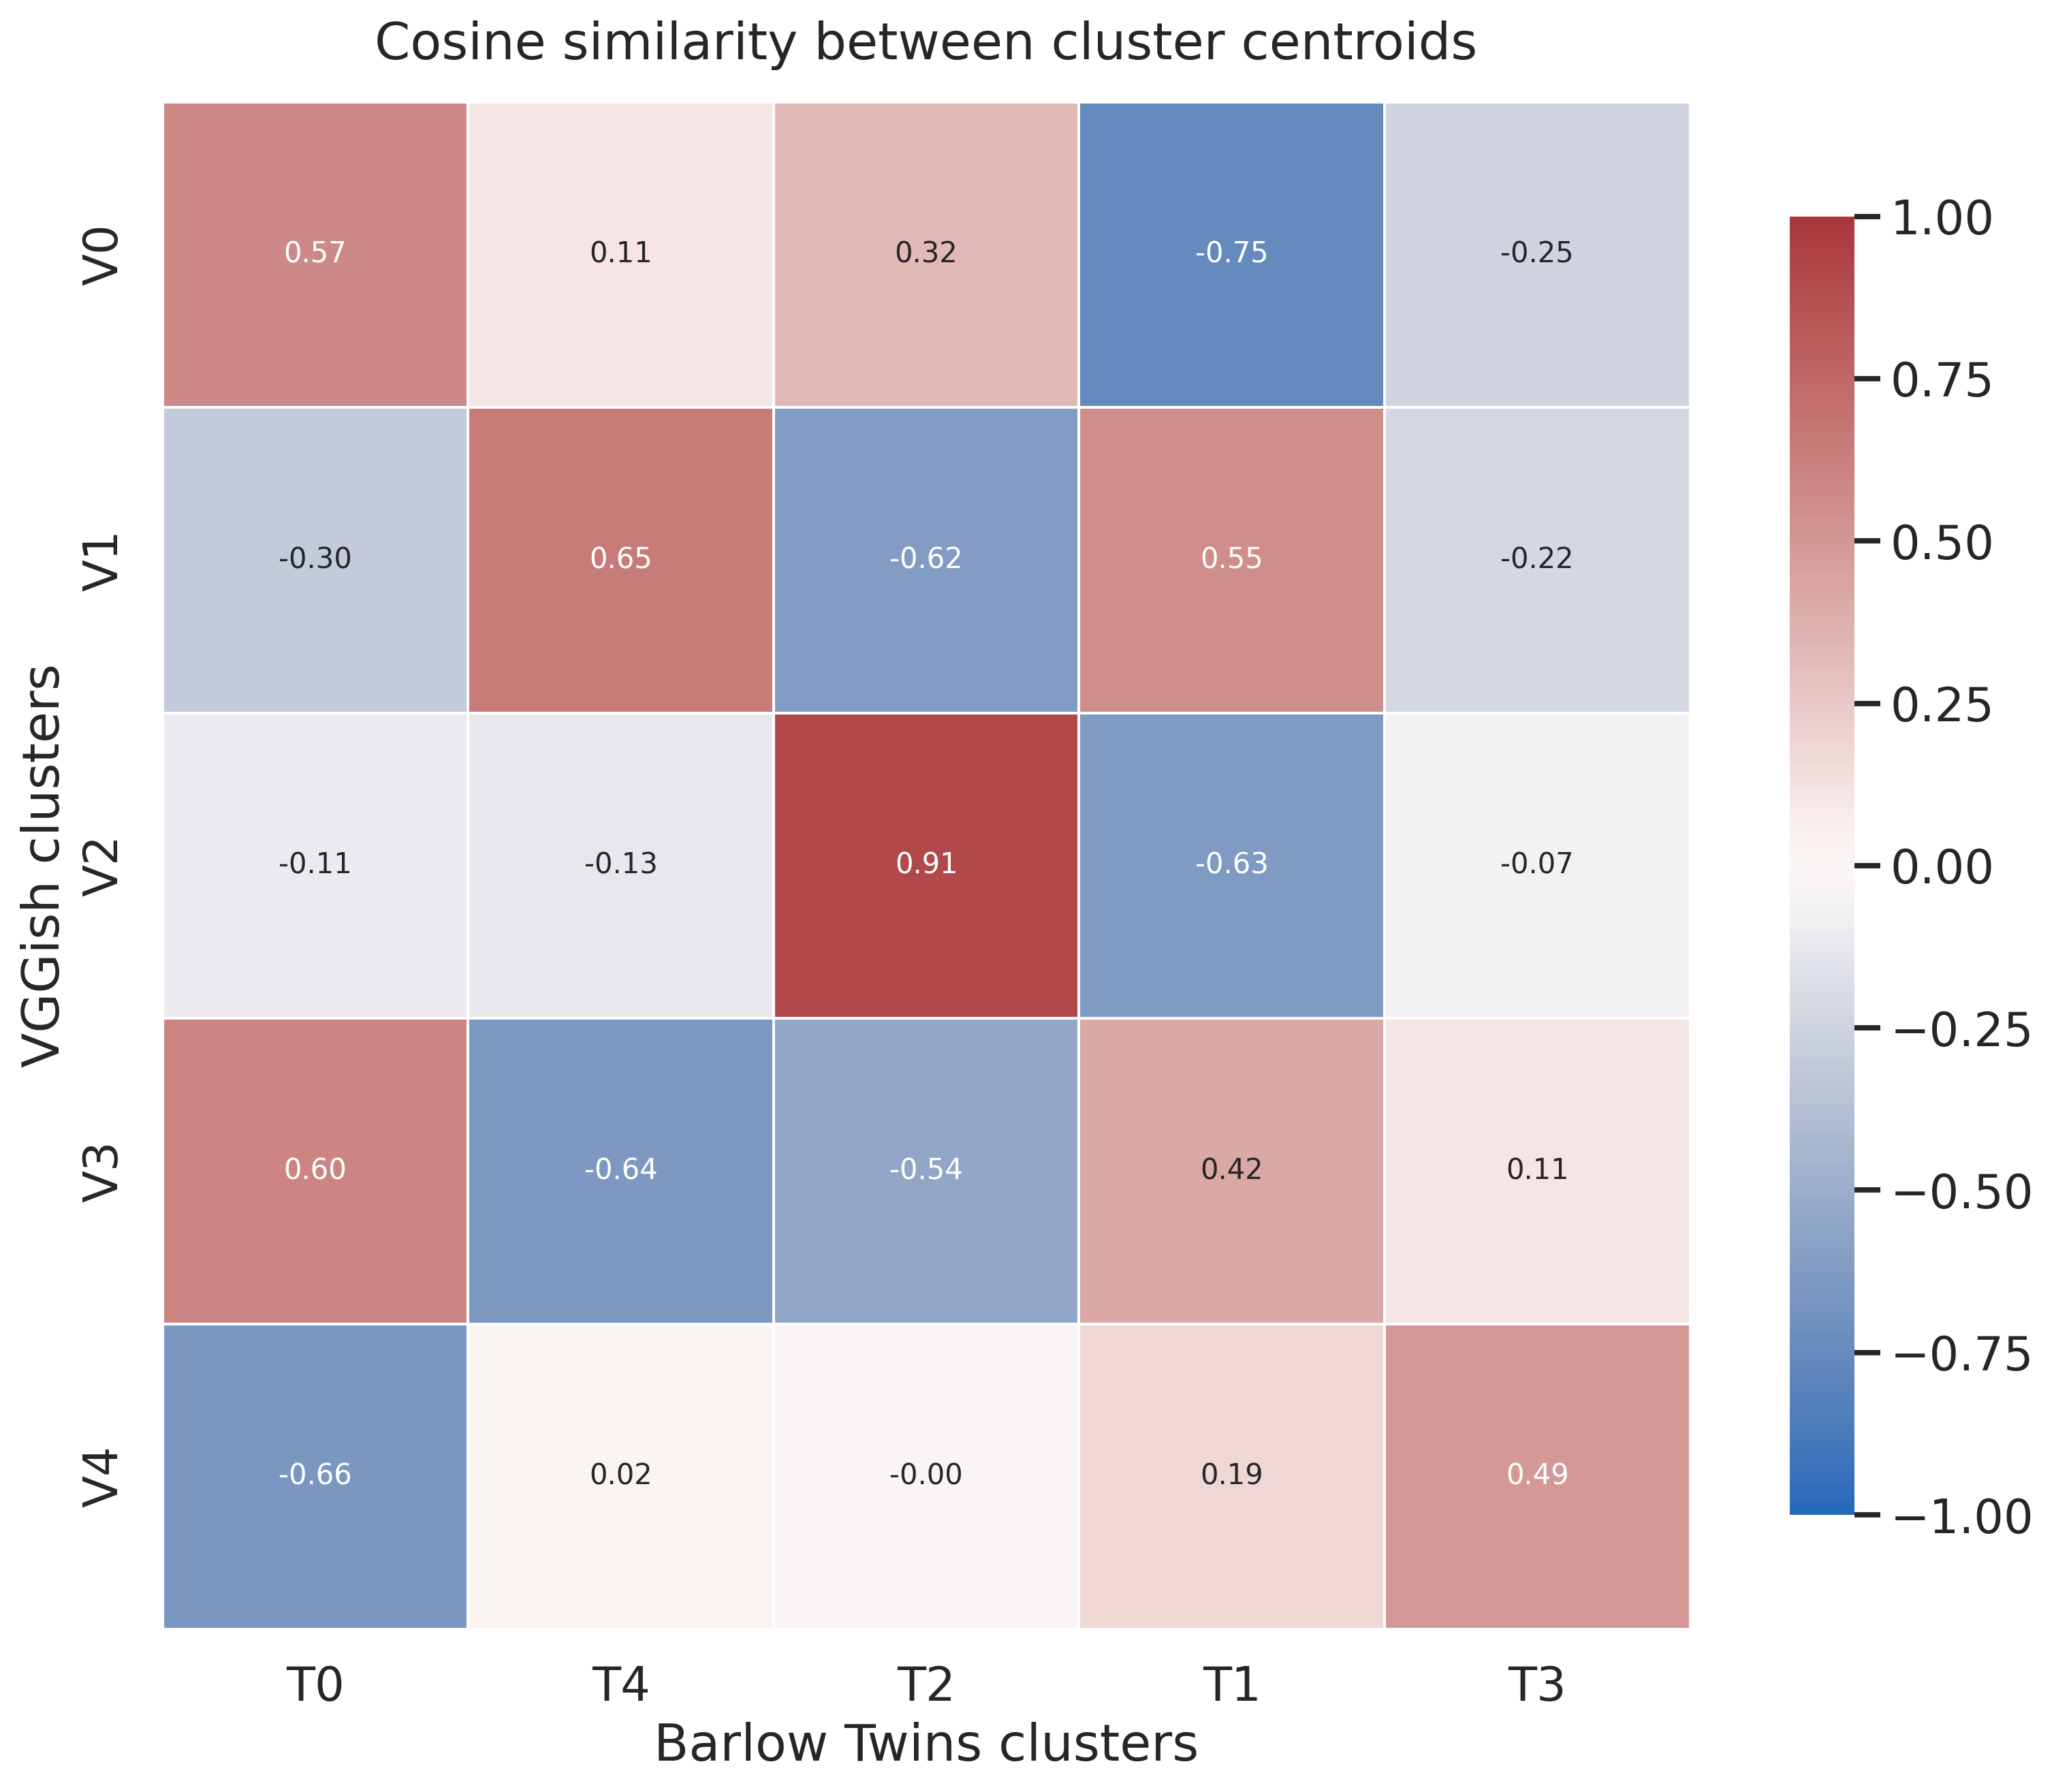

                      song  VGGish_cluster  Twins_cluster  \
0         TOOL - Lateralus               1              3   
1           TOOL - Parabol               4              2   
2  Opeth - Blackwater Park               1              2   
3  King Woman - Hierophant               4              3   
4              Low - Words               3              3   

   Twins_aligned_cluster  
0                      4  
1                      2  
2                      2  
3                      4  
4                      4  


In [ ]:
# ---------------------------------------------------------------
# --- CONFIG ---
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# File paths
PKL_PATH = "vggish_embeddings.pkl"
NPY_PATH = "song_embeddings.npy"
TXT_PATH = "song_labels.txt"

K = 5               # number of clusters
COMMON_DIM = 128    # dimensionality to project both embedding spaces


#  --- 1. LOAD EMBEDDINGS  ---

# Load VGGish: {songname.mp3: embedding}
with open(PKL_PATH, "rb") as f:
    vggish_dict = pickle.load(f)

vgg_titles = [k.replace(".mp3", "") for k in vggish_dict]
X_vgg = np.vstack(list(vggish_dict.values()))  # shape: (n, 128)

# Load Twins
X_twins = np.load(NPY_PATH)                   # shape: (m, 256)
with open(TXT_PATH) as f:
    twin_titles = [line.strip() for line in f]

#  --- 2. ALIGN COMMON SONGS  ---

twin_index = {t: i for i, t in enumerate(twin_titles)}
common_idx = [i for i, t in enumerate(vgg_titles) if t in twin_index]

X_vgg_aln = X_vgg[common_idx]
X_twins_aln = X_twins[[twin_index[vgg_titles[i]] for i in common_idx]]
titles_aligned = [vgg_titles[i] for i in common_idx]

print(f"{len(titles_aligned)} songs present in both sets")

# ---  3. STANDARDIZE & PROJECT TO COMMON DIM  ---

scaler1 = StandardScaler(); X1 = scaler1.fit_transform(X_vgg_aln)
scaler2 = StandardScaler(); X2 = scaler2.fit_transform(X_twins_aln)

pca1 = PCA(COMMON_DIM); X1_pca = pca1.fit_transform(X1)
pca2 = PCA(COMMON_DIM); X2_pca = pca2.fit_transform(X2)

# --- 4. CLUSTER BOTH SPACES (KMeans) ---

km1 = KMeans(K, random_state=0).fit(X1_pca)
km2 = KMeans(K, random_state=0).fit(X2_pca)

centroids1 = km1.cluster_centers_
centroids2 = km2.cluster_centers_

# --- 5. COSINE SIMILARITY + HUNGARIAN ALIGNMENT (DIAGONAL MATCH) ---
sim = cosine_similarity(centroids1, centroids2)  # shape: (K, K)

# Find best matching cluster pairs
row_ind, col_ind = linear_sum_assignment(-sim)

# Reorder similarity matrix for diagonal alignment
sim_diag = sim[row_ind][:, col_ind]
yticks_diag = [f"V{i}" for i in row_ind]
xticks_diag = [f"T{j}" for j in col_ind]

# ---  6. REMAP TWINS CLUSTER LABELS ACCORDING TO ALIGNMENT ---
# Map original cluster id -> aligned cluster id
twins_label_map = {orig: new for new, orig in enumerate(col_ind)}
twins_aligned_labels = [twins_label_map[label] for label in km2.labels_]

# ---  7. PLOT DIAGONAL HEATMAP ---
sns.set_theme(style="white", palette="pastel")
sns.set_context("talk")

plt.figure(figsize=(2.2 * K, 1.8 * K), dpi=300)
ax = sns.heatmap(
    sim_diag,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.85},
    xticklabels=xticks_diag,
    yticklabels=yticks_diag,
    annot_kws={"fontsize": 10}
)

ax.set_xlabel("Barlow Twins clusters")
ax.set_ylabel("VGGish clusters")
ax.set_title("Cosine similarity between cluster centroids", pad=15)
plt.tight_layout()
plt.show()

# ---  8. EXPORT CLUSTER ASSIGNMENTS ---
df_clusters = pd.DataFrame({
    "song": titles_aligned,
    "VGGish_cluster": km1.labels_,
    "Twins_cluster": km2.labels_,
    "Twins_aligned_cluster": twins_aligned_labels
})

print(df_clusters.head())
Optional: df_clusters.to_csv("aligned_cluster_assignments.csv", index=False)
